In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import PIL
import urllib
from tqdm.notebook import tqdm

import timm
import fastai.vision.all as fastai
from fastai.callback.schedule import Learner
from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

seed = 42
np.random.seed(seed + 1)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cpu


# Segmentation

Goal: Given an image, learn a mask of the same size, where each value stands for some category.

Types:
- Semantic Segmentation: Segment the image by the categories that show up
- Instance Segmentation: Segment the image by both the category and the number of segments in that category
- Panoptic Segmentation: Segment the image using pixel-by-pixel object detection

## U-Nets

Transpose Convolution: Used to make the input height/width larger. Undoes convolution in some sense.
- Given $(k,k)$ filter on an input $(h,w)$. The output size is $(h',w')$, initialized to zeros.
- For each element in the input, multiply it by the filter to get a $(k,k)$ window.
- Place the window over the correct spot in the output. Note padding and stride may be used on the output.
- For each value in the window, sum the window value with the current output value, and update the output value.
- Do this until the window convolves over the entire input.

U-Nets: A bottleneck network that squeezes an image down to linear features and then blows it back up into a mask.
- The idea is that compression allows the model to learn the essential features in the image, while decompression allows it to blow back up and learn a mask representation for segmentation.
- Convolution blocks with pooling are used to shrink the image down to a linear representation.
- Transpose convolution blocks are used to blow the representation back up to a mask the same height/width as the image (but with only one channel).
- Residual connections connect blocks of the same size across the U-Net, allowing intermediate features to transfer from input to output. Channel-wise concatenation is used instead of summing.

<img src="https://pytorch.org/assets/images/unet_brain_mri.png" alt="U-Net" width="500"/>

In [2]:
model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch',
    'unet', 
    in_channels=3, 
    out_channels=1, 
    init_features=32, 
    pretrained=True
)

Using cache found in /Users/rkingery/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [4]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

In [22]:
data_path = fastai.untar_data(fastai.URLs.CAMVID_TINY)
data_path

Path('/Users/rkingery/.fastai/data/camvid_tiny')

In [23]:
codes = np.loadtxt(data_path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [24]:
fnames = fastai.get_image_files(data_path/"images")
fnames[0]

Path('/Users/rkingery/.fastai/data/camvid_tiny/images/0006R0_f02550.png')

In [26]:
(data_path/"labels").ls()[0]

Path('/Users/rkingery/.fastai/data/camvid_tiny/labels/Seq05VD_f02070_P.png')

In [30]:
def label_func(fn): 
    return data_path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [32]:
dls = fastai.SegmentationDataLoaders.from_label_func(data_path, bs=8, fnames=fnames, 
                                                     label_func=label_func, codes=codes)

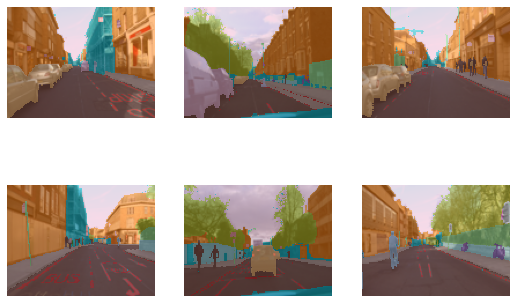

In [33]:
dls.show_batch(max_n=6)

In [40]:
learn = fastai.unet_learner(dls, fastai.resnet18)
learn.lr_find()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/rkingery/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
learn.fine_tune(6)

# Object Detection

- Objection Detection: Object Recognition + Object Localization + Multiple Objects
- Object Recognition: Classify given object according to a set of classes
- Object Localization: Learn the bounding box for a particular object
- Multiple Objects: Need to recognize a set of objects, not necessarily a fixed number of them (or any at all)

In [ ]:
torchvision.datasets.

In [ ]:
torchvision.models.detection.

In [20]:
model

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra